# Compare subnational industry end use statistics

Very few datasets exist on the end-use energy consumption in industry, let alone within industry subsectors. 
Here we compare three data sources: the FORECAST-Industry database, Austrian government statistics, and the JRC-IDEES database. 

The result is that they rarely agree. 
The FORECAST-Industry modellers admit that their data performs poorly when compared to published statistics; it is not straightforward to discover whether this casts doubt on one or other database (or, indeed, both).
Since there is no reliable ground-truth, we ultimately use the JRC-IDEES database, since it provides the closest match in data structure to Eurostat.

In [26]:
import sys

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../src/construct/')
import util

idx = pd.IndexSlice

data_path = '../../data/industry/'

In [5]:
# Load datasets

FORECAST_2015 = pd.read_csv(data_path + 'FORECAST-industry_2015_end_use_consumption.csv', index_col=[0, 1, 2, 3], squeeze=True, header=0)
FORECAST_2012 = pd.read_csv(data_path + 'FORECAST-industry_2012_end_use_consumption.csv', index_col=[0, 1, 2], squeeze=True, header=0)
JRC_IDEES =  pd.read_csv(data_path + 'JRC_jrc_idees_processed_energy.csv.gz', index_col=[0, 1, 2, 3, 4, 5], squeeze=True, header=0).xs("consumption", level="energy")
published_data = pd.read_csv(data_path + '/published_industry_end_use_consumption.csv', index_col=[0, 1, 2, 3, 4], squeeze=True, header=0)

# Compare Autria published stats for 2012 and the FORECAST-Industry model data for the same year

In [19]:
# Extract Austrian data - copy from 'process_published_industry_end_use_datasets.ipynb'
def get_at_end_use_df(year=None, region=None):
    files = {
        'AT': '066288',  # NUTS0
        'AT11': '066289',  # NUTS2
        'AT12': '066291',  # NUTS2
        'AT13': '066297',  # NUTS2
        'AT21': '066290',  # NUTS2
        'AT22': '066294',  # NUTS2
        'AT31': '066292',  # NUTS2
        'AT32': '066293',  # NUTS2
        'AT33': '066295',  # NUTS2
        'AT34': '066296'  # NUTS2
    }
    if region is not None:
        files = {region: files[region]}
    if year is not None:
        years = [year]
    else:
        years = range(2005, 2018)
    end_uses = []
    
    for region, filecode in files.items():
        for year in years:
            _end_use_demand = pd.read_excel(
                f'https://www.statistik.at/wcm/idc/idcplg?IdcService=GET_NATIVE_FILE&RevisionSelectionMethod=LatestReleased&dDocName={filecode}', 
                sheet_name=f'NEA {year}', usecols="U:AI", skiprows=30, header=None
            ).dropna()
            table_ends = _end_use_demand[_end_use_demand[20] == 'Peat'].index
            dfs = []

            for i in range(0, len(table_ends)):
                if i == 0:
                    _df = _end_use_demand.loc[:table_ends[i] + 1]
                else:
                    _df = _end_use_demand.loc[table_ends[i - 1] + 1:table_ends[i] + 1]

                _df = _df.set_index(20).drop(['Shares', 'TOTAL', 0], errors='ignore')
                _df.columns = _df.iloc[0].values
                _df.rename(
                    columns={'Indust. furnaces': 'Industrial furnaces',
                            'of which electochemical purp.': 'of which electochemical purposes'}, 
                    inplace=True
                )
                _df.index.set_names('carrier_name', inplace=True)
                _df = _df.assign(cat_name=_df.iloc[0].name)
                _df = _df.drop(_df.iloc[0].name).drop(['Other', 'Total'], axis=1)
                _df.columns = (
                    _df.columns
                    .str.lower()
                    .str.replace("of which ", "")
                    .str.replace(" & ", "_")
                    .str.replace(" ", "_")
                )
                _df = _df.set_index('cat_name', append=True)

                dfs.append(_df)
            end_uses.append(
                pd.concat(dfs, sort=True)
                .sort_index()
                .assign(region=region, year=year, unit='TJ')
                .set_index(['region', 'year', 'unit'], append=True)
            )
    return pd.concat(end_uses, sort=True)

In [121]:
forecast_at = (
    FORECAST_2012
    .xs('Austria', level='country_name')
    .unstack(1).groupby({
        'District heating': 'District heating', 
        'Electricity': 'Electricity', 
        'Other fossil': 'Other fossil', 
        'Natural gas': 'Natural gas',
        'Fuel oil': 'Fuel oil',
        'other': 'other', 
        'Solar energy': 'Ambient and solar heat', 
        'Ambient heat': 'Ambient and solar heat', 
        'Geothermal': 'Geothermal', 
        'Coal': 'Coal', 
        'Biomass': 'Biomass', 
        'Waste RES': 'Waste',
        'Waste non-RES': 'Waste',
        'Other RES': 'other'
    }).sum()
    .T
)

forecast_at_sh = forecast_at.xs('space_heating')
forecast_at_ph = forecast_at.drop('space_heating', level=0).sum(level='cat_name')

at_compare_with_forecast = (
    get_at_end_use_df(year=2012, region='AT')
    .xs(('AT', 2012, 'TJ'), level=('region', 'year', 'unit'))
    .unstack('carrier_name')
    .drop('MANUFACTURING INDUSTRIES IN TOTAL')
    .apply(util.tj_to_twh)
    .groupby({
        'Chemical and petrochemical industry': 'Chemical and Petrochemical',
        'Construction': 'Other Industry',
        'Food, tabacco and beverages': 'Food, Beverages and Tabacco',
        'Iron and steel': 'Iron and Steel',
        'Machinery': 'Machinery and transport',
        'Mining and quarrying': 'Other Industry',
        'Non ferrous metals': 'Non-ferrous metals',
        'Non metalic minerals': 'Non-metallic minerals',
        'Non specified industry': 'Other Industry',
        'Paper, pulp and print': 'Paper, Pulp and Printing',
        'Textiles and leather': 'Other Industry',
        'Transport equipment': 'Machinery and transport',
        'Wood and wood products': 'Other Industry'
    }).sum()
    .reindex(forecast_at_sh.index)
    .stack(1).unstack(0)
    .groupby({
        'Ambient and solar heat': 'Ambient and solar heat',
        'Biofuels': 'Biomass',
        'Blast furnace gas': 'Other fossil',
        'Coke oven coke': 'Other fossil',
        'Coke oven gas': 'Other fossil',
        'Diesel': 'Other fossil',
        'District heat': 'District heating',
        'Electricity': 'Electricity',
        'Fuel oil': 'Fuel oil',
        'Fuel wood': 'Biomass',
        'Gas oil': 'Other fossil',
        'Gasoline': 'Other fossil',
        'Hard coal': 'Coal',
        'Kerosene': 'Other fossil',
        'LPG': 'Other fossil',
        'Lignite': 'Coal',
        'Natural gas': 'Natural gas',
        'Other energy sources': 'other',
        'Peat': 'other',
        'Petrol coke': 'Other fossil',
        'Waste': 'Waste'
    }).sum()
    .reindex(forecast_at_sh.columns)
    .T
)
    

at_compare_with_forecast_sh = at_compare_with_forecast.xs('space_heating')
at_compare_with_forecast_ph = at_compare_with_forecast.loc[
    (['drying', 'industrial_furnaces', 'vapor_production', 'water_heating'], ), :
].sum(level='cat_name')

jrc_compare_with_forecast = (
    JRC_IDEES
    .xs(('AT', 2012), level=('country_code', 'year'))
    .unstack(['carrier_name', 'end_use'])
    .groupby({
        'Chemicals Industry': 'Chemical and Petrochemical',
        'Food, beverages and tobacco': 'Food, Beverages and Tabacco',
        'Iron and steel': 'Iron and Steel',
        'Machinery Equipment': 'Machinery and transport',
        'Non Ferrous Metals': 'Non-ferrous metals',
        'Non-metallic mineral products': 'Non-metallic minerals',
        'Other Industrial Sectors': 'Other Industry',
        'Pulp, paper and printing': 'Paper, Pulp and Printing',
        'Textiles and leather': 'Other Industry',
        'Transport Equipment': 'Machinery and transport',
        'Wood and wood products': 'Other Industry'
    }).sum()
    .reindex(forecast_at_sh.index)
    .stack(0).unstack(0)
    .groupby({
        'biofuel': 'Biomass',
        'electricity': 'Electricity',
        'heat': 'District heating',
        'manufactured_gas': 'Other fossil',
        'natural_gas': 'Natural gas',
        'oil': 'Other fossil',
        'renewable_heat': 'Ambient and solar heat',
        'solid_fuel': 'Coal'
    }).sum()
    .reindex(forecast_at_sh.columns)
    .T
)
jrc_compare_with_forecast_sh = jrc_compare_with_forecast.xs('space_heating')
jrc_compare_with_forecast_ph = jrc_compare_with_forecast.xs('process_heating')

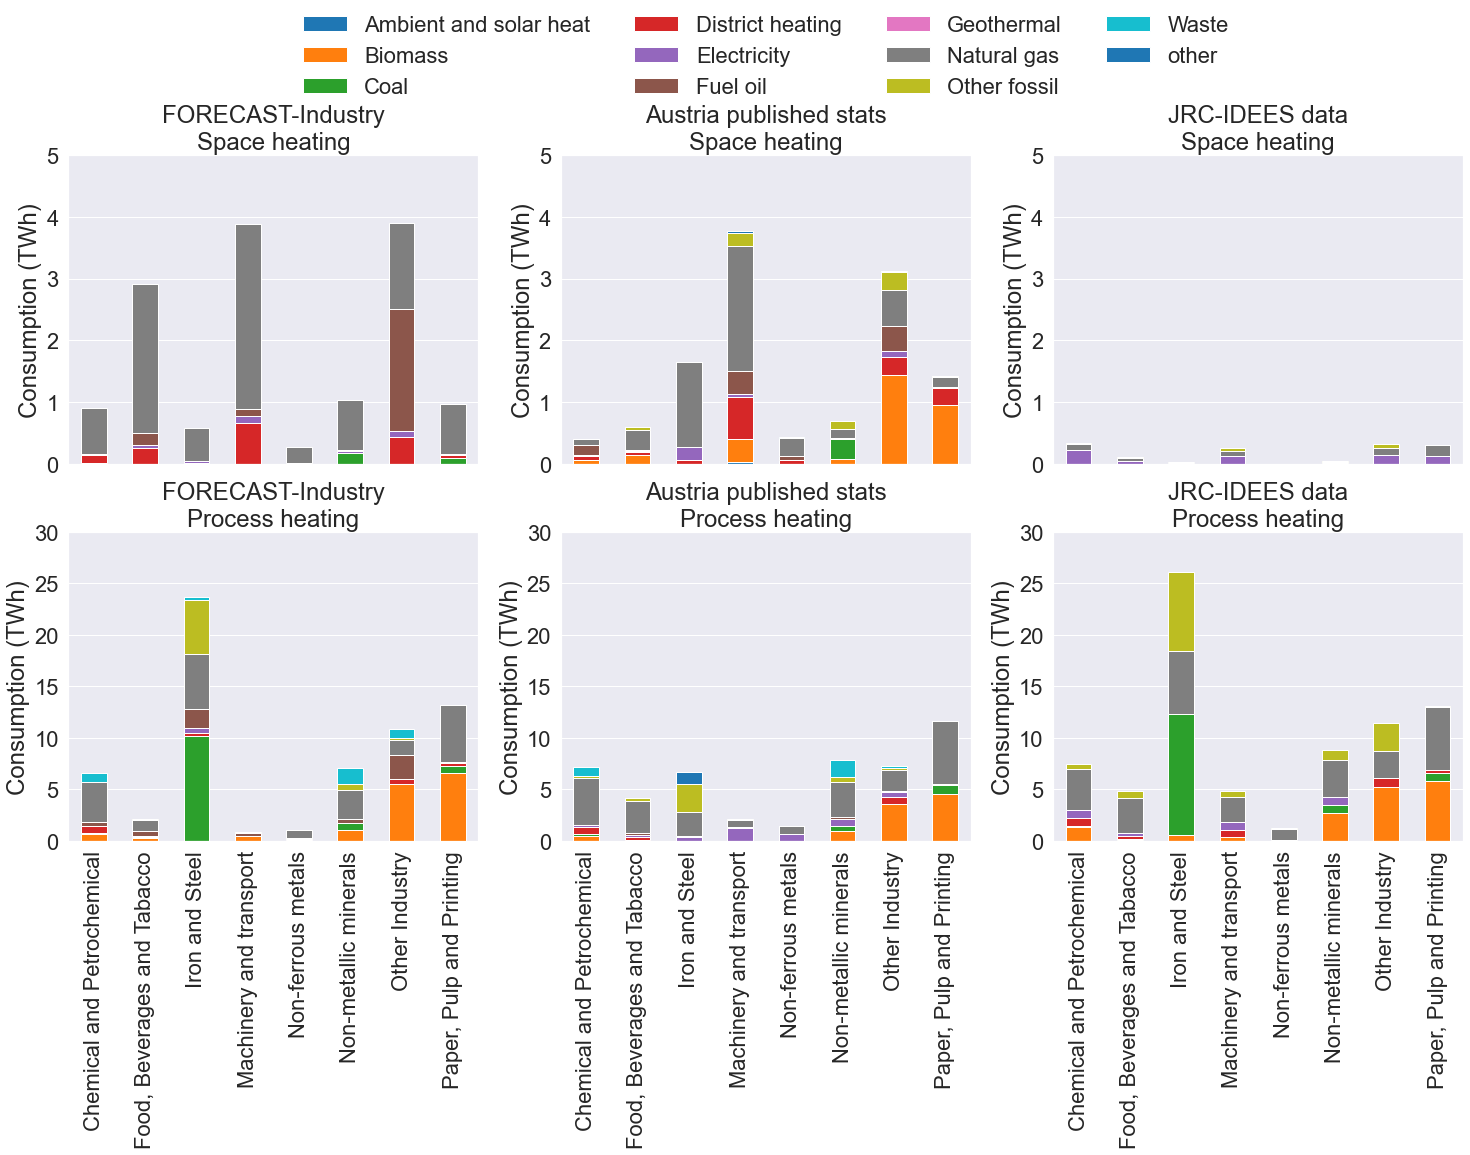

In [125]:
with sns.plotting_context("notebook", font_scale=2):
    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(25, 15))
    g = plt.GridSpec(3, 3, figure=fig, height_ratios=(2, 10, 10), hspace=0.3)
    ax1 = fig.add_subplot(g[1, 0])
    ax2 = fig.add_subplot(g[1, 1])
    ax3 = fig.add_subplot(g[2, 0])
    ax4 = fig.add_subplot(g[2, 1])
    ax5 = fig.add_subplot(g[1, 2])
    ax6 = fig.add_subplot(g[2, 2])
    cax = fig.add_subplot(g[0, :])

    forecast_at_sh.plot.bar(
        ax=ax1, stacked=True, title='FORECAST-Industry\nSpace heating'
    )
    at_compare_with_forecast_sh.plot.bar(
        ax=ax2, stacked=True, legend=False, title='Austria published stats\nSpace heating'
    )
    jrc_compare_with_forecast_sh.plot.bar(
        ax=ax5, stacked=True, legend=False, title='JRC-IDEES data\nSpace heating'
    )
    handles, labels = ax1.get_legend_handles_labels()
    ax1.get_legend().remove()

    for i in [ax1, ax2, ax5]:
        i.set_ylim(0, 5)
        i.set_ylabel('Consumption (TWh)')
        i.xaxis.set_visible(False)
        i.grid(b=None, axis='x')
        i.grid(b=True, axis='y')

    forecast_at_ph.plot.bar(
        ax=ax3, stacked=True, legend=False, title='FORECAST-Industry\nProcess heating'
    )
    at_compare_with_forecast_ph.plot.bar(
        ax=ax4, stacked=True, legend=False, title='Austria published stats\nProcess heating'
    )
    jrc_compare_with_forecast_ph.plot.bar(
        ax=ax6, stacked=True, legend=False, title='JRC-IDEES data\nProcess heating'
    )
    handles, labels = ax1.get_legend_handles_labels()
    for i in [ax3, ax4, ax6]:
        i.set_ylim(0, 30)
        i.set_xlabel('')
        i.set_ylabel('Consumption (TWh)')
        i.grid(b=None, axis='x')
        i.grid(b=True, axis='y')

    cax.axis('off')
    cax.legend(handles=handles, labels=labels, ncol=4, loc='center', frameon=False)

# Compare published data with JRC and FORECAST data for the year 2015

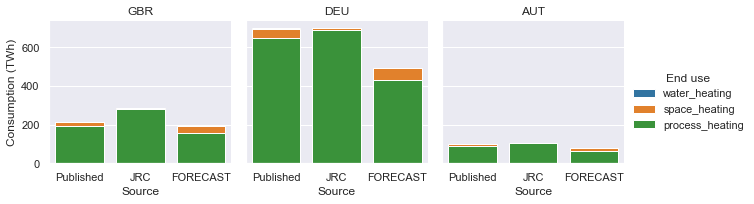

In [31]:
# Aggregated carriers and subsectors
_published_data = (
    published_data
    .drop('CH', level='country_code')  # no JRC or FORECAST data for Switzerland
    .unstack('year')
    .sum(level=['country_code', 'end_use'])
)
published_data_2015 = (
    _published_data
    .where(_published_data > 0)
    [2015]
    .fillna(_published_data[2016])  # No data for 2015 in UK, so we use the next best thing: 2016 data
)

data_to_compare = pd.concat([
    published_data_2015,
    JRC_IDEES.unstack('year').sum(level=['country_code', 'end_use'])[2015].loc[(['AT', 'DE', 'UK'], )],
    FORECAST_2015.xs('industry', level='cat_name').sum(level=['country_code', 'end_use']).loc[(['AUT', 'DEU', 'GBR'], )]
], names=['source'], keys=['Published', 'JRC', 'FORECAST'])

_df = (
    data_to_compare
    .unstack([0, 2])
    .groupby(util.get_alpha3).sum()
    .stack(0)
    .sort_index(axis=1)
    .cumsum(axis=1)
    .stack()
    .rename_axis(index=['country_code', 'Source', 'End use'])
    .to_frame('Consumption (TWh)')
    .reset_index()
    .sort_values('End use')
) 
with sns.plotting_context("notebook", font_scale=1):
    sns.set_style("darkgrid")
    g = sns.FacetGrid(
        _df[_df['End use'].isin(['process_heating', 'space_heating', 'water_heating'])],
        col="country_code", 
        hue="End use",  
        hue_order=['water_heating', 'space_heating', 'process_heating'],
    )
    g.map(
        sns.barplot, 'Source', 'Consumption (TWh)', order=_df.Source.unique()
    )
    g.add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

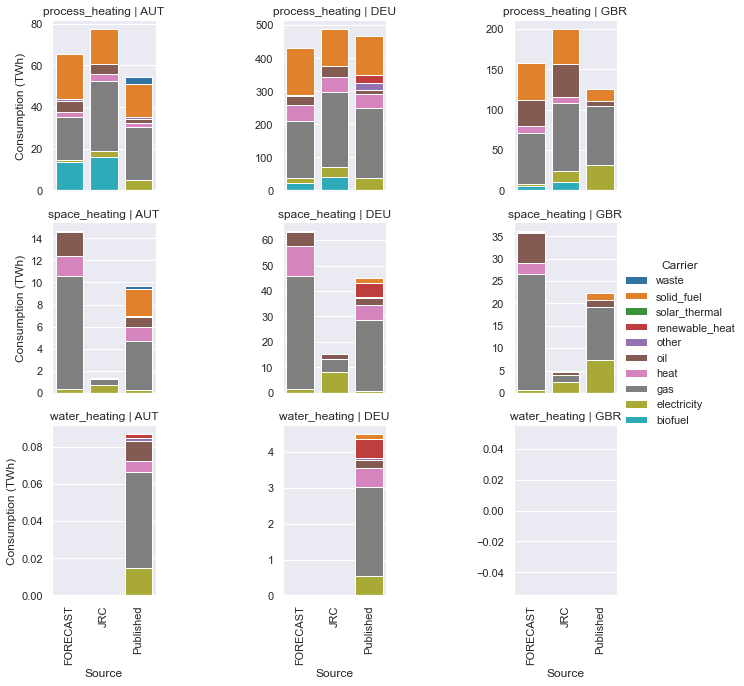

In [97]:
# Aggregated subsectors
_published_data = (
    published_data
    .drop('CH', level='country_code')  # no JRC or FORECAST data for Switzerland
    .unstack('year')
    .sum(level=['country_code', 'end_use', 'carrier_name'])
)
published_data_2015 = (
    _published_data
    .where(_published_data > 0)
    [2015]
    .fillna(_published_data[2016])  # No data for 2015 in UK, so we use the next best thing: 2016 data
)

data_to_compare = pd.concat([
    published_data_2015,
    JRC_IDEES.unstack('year').sum(level=['country_code', 'end_use', 'carrier_name'])[2015].loc[(['AT', 'DE', 'UK'], )],
    FORECAST_2015.xs('industry', level='cat_name').sum(level=['country_code', 'end_use', 'carrier_name']).loc[(['AUT', 'DEU', 'GBR'], )]
], names=['source'], keys=['Published', 'JRC', 'FORECAST'])

_df = (
    data_to_compare
    .unstack([0, 2, 3])
    .groupby(util.get_alpha3).sum()
    .stack([0, 1])
    .rename(columns={
     'biomass': 'biofuel', 'district_heat': 'heat', 
     'manufactured_gas': 'gas', 'natural_gas': 'gas', 
     'other_renewable': 'other', 'solid_fossil': 'solid_fuel'
    })
    .groupby(axis=1, level=0).sum()
    .sort_index(axis=1)
    .cumsum(axis=1)
    .stack()
    .rename_axis(index=['country_code', 'Source', 'End use', 'Carrier'])
    .to_frame('Consumption (TWh)')
    .reset_index()
)
with sns.plotting_context("notebook", font_scale=1):
    sns.set_style("darkgrid")
    g = sns.FacetGrid(
        _df[_df['End use'].isin(['process_heating', 'space_heating', 'water_heating'])],
        col="country_code", 
        row="End use",
        hue="Carrier",  
        hue_order=_df.Carrier.unique()[::-1],
        sharey=False
    )
    g.map(
        sns.barplot, 'Source', 'Consumption (TWh)', order=_df.Source.unique()
    )
    g.add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
foo = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]